In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [8]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

In [11]:
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
display(daily_item_counts.head(10))

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14
5,2023-03-01,Espresso,6
6,2023-03-01,Hot Chocolate,4
7,2023-03-01,Latte,24
8,2023-03-02,Americano,19
9,2023-03-02,Americano with Milk,26


In [12]:
def create_item_features(df):
    # date เป็น datetime
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.set_index('date', inplace=True)

    # Feature จากวันเวลา
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year

    # Lag และ Rolling
    df.sort_index(inplace=True)
    df['lag_7'] = df['count'].shift(7)
    df['lag_14'] = df['count'].shift(14)
    df['rolling_mean_7'] = df['count'].shift(1).rolling(window=7).mean()

    df.reset_index(inplace=True)
    return df

In [13]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'count'

# Dictionary เก็บผลลัพธ์
future_preds = {}

# วันที่แบ่ง Train/Test
split_date = '2025-03-01'

In [14]:
for coffee in daily_item_counts['coffee_name'].unique():
    print(f"\n===== Training model for: {coffee} =====")

    # เลือกเฉพาะเมนูนี้
    coffee_data = daily_item_counts[daily_item_counts['coffee_name'] == coffee].copy()
    coffee_features = create_item_features(coffee_data)
    coffee_features.dropna(inplace=True)

    X = coffee_features[FEATURES]
    y = coffee_features[TARGET]

    # Train/Test Split ตามเวลา
    coffee_features['date'] = pd.to_datetime(coffee_features['date'])
    train = coffee_features[coffee_features['date'] < split_date]
    test = coffee_features[coffee_features['date'] >= split_date]

    X_train, y_train = train[FEATURES], train[TARGET]
    X_test, y_test = test[FEATURES], test[TARGET]

    # สร้าง Model (ใช้ RandomForest)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # ประเมิน Model เบื้องต้น
    if len(X_test) > 0:
        preds_test = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds_test)
        print(f"MAE on Test Set: {mae:.2f}")

    # ทำนายค่าในอนาคต
    last_date = coffee_features['date'].max()
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)
    future_df = pd.DataFrame({'date': future_dates})
    future_df['dayofweek'] = future_df['date'].dt.dayofweek
    future_df['quarter'] = future_df['date'].dt.quarter
    future_df['month'] = future_df['date'].dt.month
    future_df['dayofyear'] = future_df['date'].dt.dayofyear
    future_df['year'] = future_df['date'].dt.year

    # ใช้ค่า lag/rolling จากข้อมูลล่าสุด
    last_vals = coffee_features.iloc[-14:]
    future_df['lag_7'] = last_vals['count'].iloc[-7:].mean()
    future_df['lag_14'] = last_vals['count'].iloc[-14:].mean()
    future_df['rolling_mean_7'] = last_vals['count'].rolling(window=7).mean().iloc[-1]

    preds_future = model.predict(future_df[FEATURES])

    # เก็บผลลัพธ์
    future_preds[coffee] = pd.DataFrame({'date': future_dates, 'coffee_name': coffee, 'predicted_count': preds_future})


===== Training model for: Americano =====
MAE on Test Set: 4.60

===== Training model for: Americano with Milk =====
MAE on Test Set: 5.55

===== Training model for: Cappuccino =====
MAE on Test Set: 4.05

===== Training model for: Cocoa =====
MAE on Test Set: 2.30

===== Training model for: Cortado =====
MAE on Test Set: 2.88

===== Training model for: Espresso =====
MAE on Test Set: 1.52

===== Training model for: Hot Chocolate =====
MAE on Test Set: 2.86

===== Training model for: Latte =====
MAE on Test Set: 4.88


In [15]:
last_date = coffee_features['date'].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=60)

In [16]:
future_df = pd.DataFrame({'date': future_dates})
future_df['dayofweek'] = future_df['date'].dt.dayofweek
future_df['quarter'] = future_df['date'].dt.quarter
future_df['month'] = future_df['date'].dt.month
future_df['dayofyear'] = future_df['date'].dt.dayofyear
future_df['year'] = future_df['date'].dt.year

# ใช้ค่า lag/rolling จากข้อมูลล่าสุด
last_vals = coffee_features.iloc[-14:]
future_df['lag_7'] = last_vals['count'].iloc[-7:].mean()
future_df['lag_14'] = last_vals['count'].iloc[-14:].mean()
future_df['rolling_mean_7'] = last_vals['count'].rolling(window=7).mean().iloc[-1]

preds_future = model.predict(future_df[FEATURES])

In [17]:
future_all = pd.concat(future_preds.values()).reset_index(drop=True)
display(future_all.head(20))

,date,coffee_name,predicted_count
0,2025-05-01,Americano,6.44
1,2025-05-02,Americano,7.10
2,2025-05-03,Americano,5.60
3,2025-05-04,Americano,5.54
4,2025-05-05,Americano,6.88
5,2025-05-06,Americano,6.81
6,2025-05-07,Americano,6.64
7,2025-05-08,Americano,6.29
8,2025-05-09,Americano,7.17
9,2025-05-10,Americano,5.64


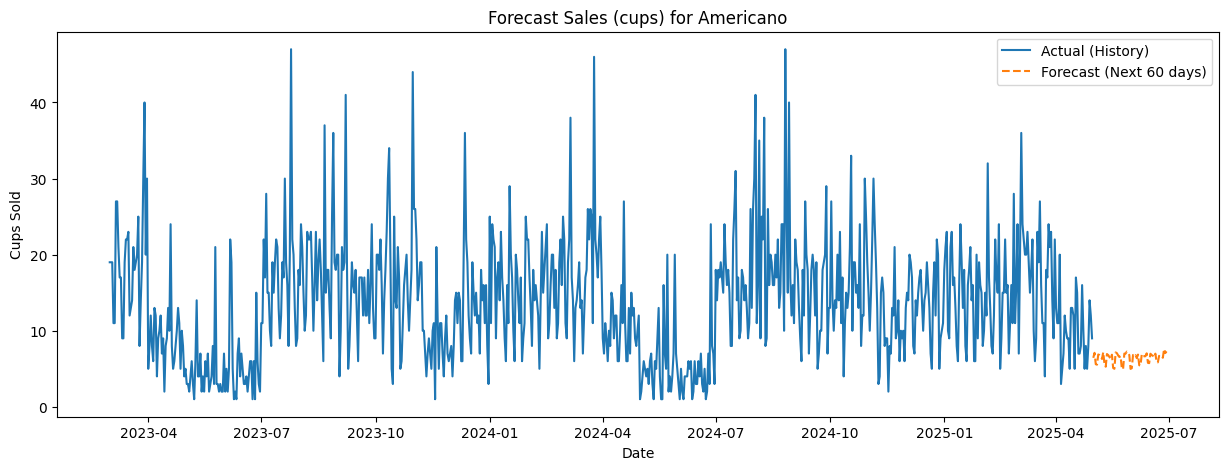

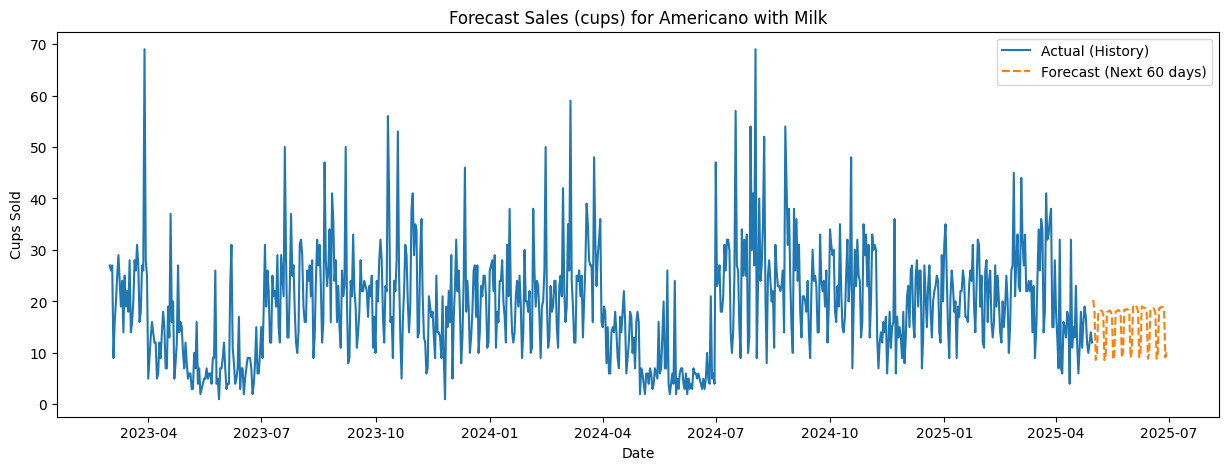

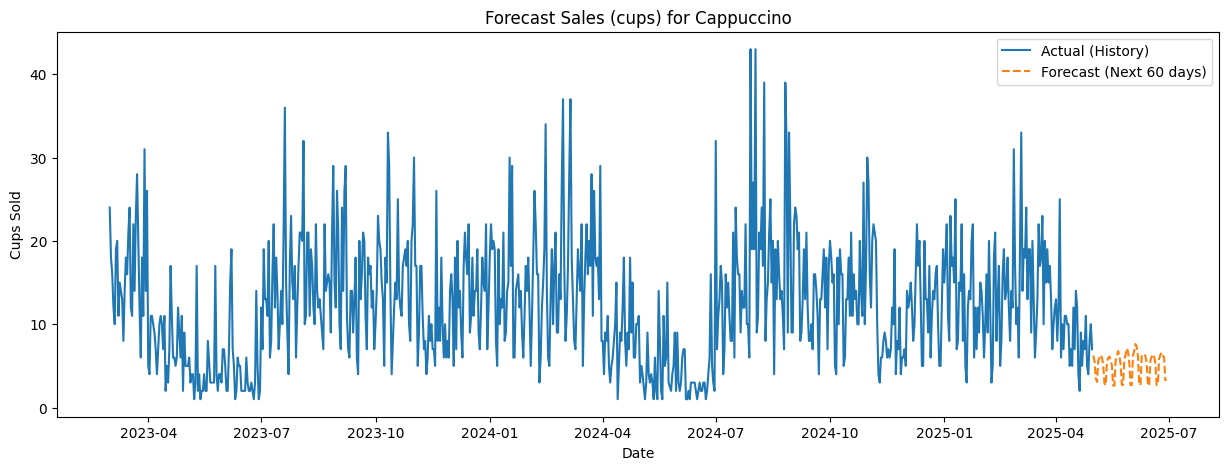

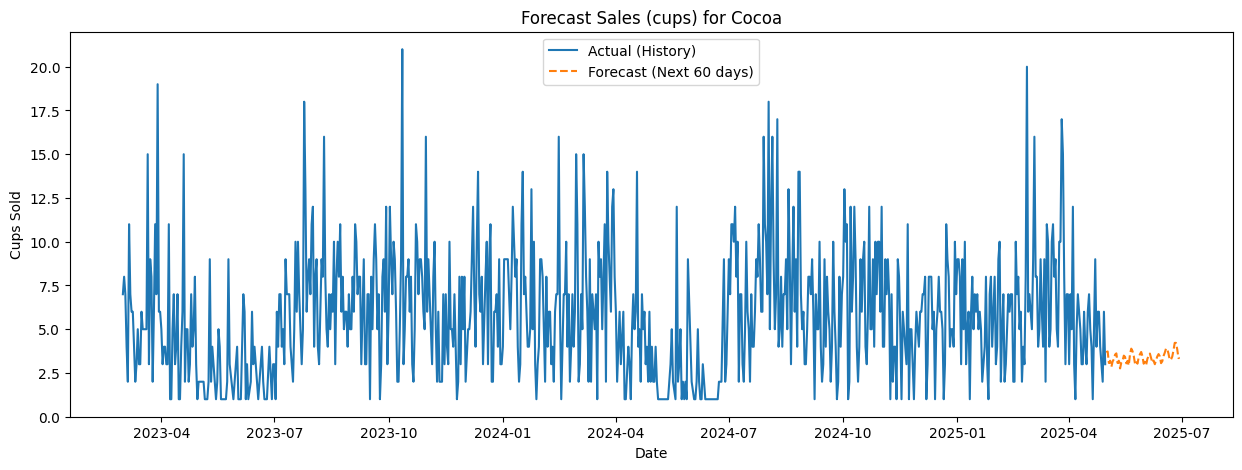

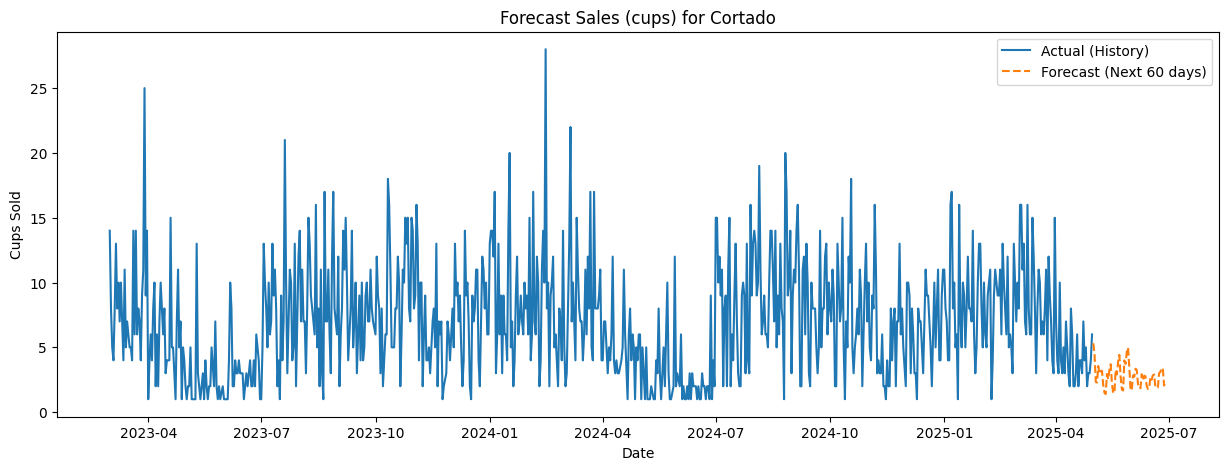

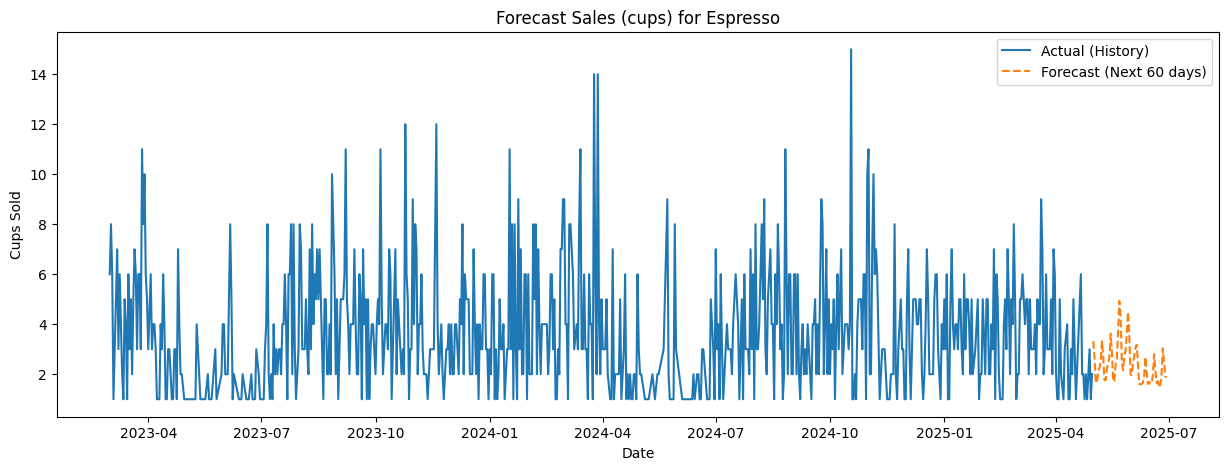

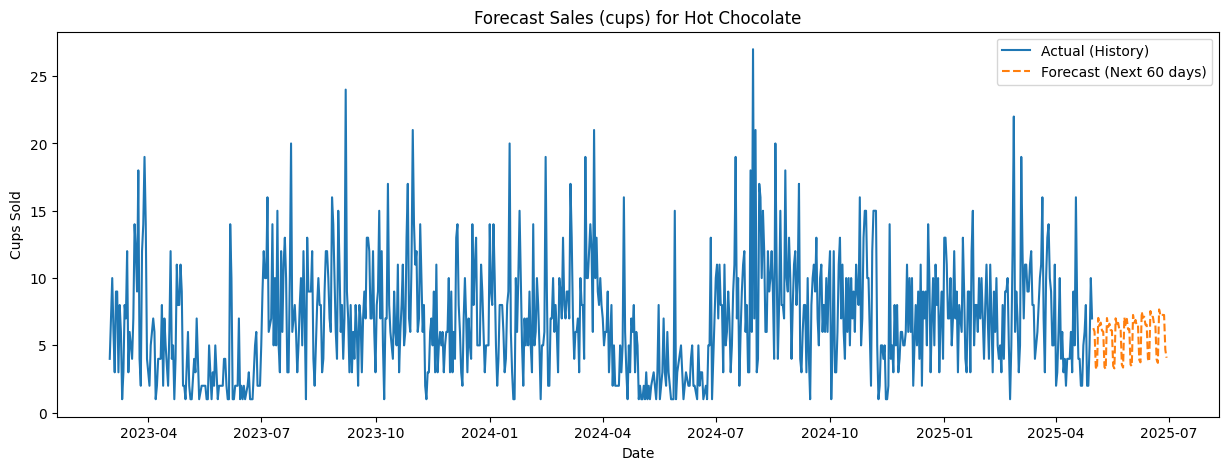

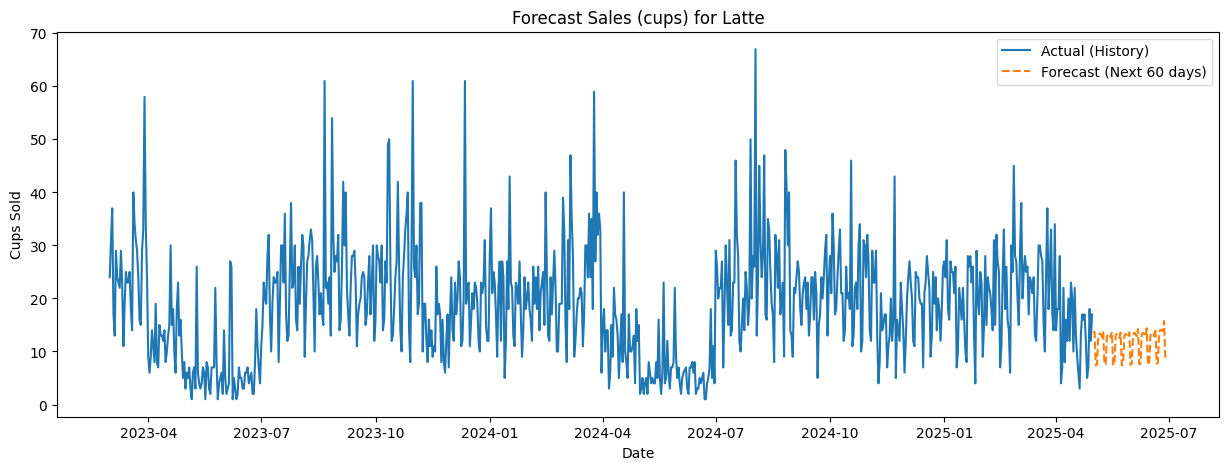

In [18]:
for coffee in daily_item_counts['coffee_name'].unique():
    plt.figure(figsize=(15, 5))
    history = daily_item_counts[daily_item_counts['coffee_name'] == coffee]
    future = future_all[future_all['coffee_name'] == coffee]

    plt.plot(history['date'], history['count'], label='Actual (History)')
    plt.plot(future['date'], future['predicted_count'], '--', label='Forecast (Next 60 days)')

    plt.title(f"Forecast Sales (cups) for {coffee}")
    plt.xlabel("Date")
    plt.ylabel("Cups Sold")
    plt.legend()
    plt.show()

In [20]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [22]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [23]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [24]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [25]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} แก้ว")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 4.88 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 5.00 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 1142.00 แก้ว


In [27]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test['date']

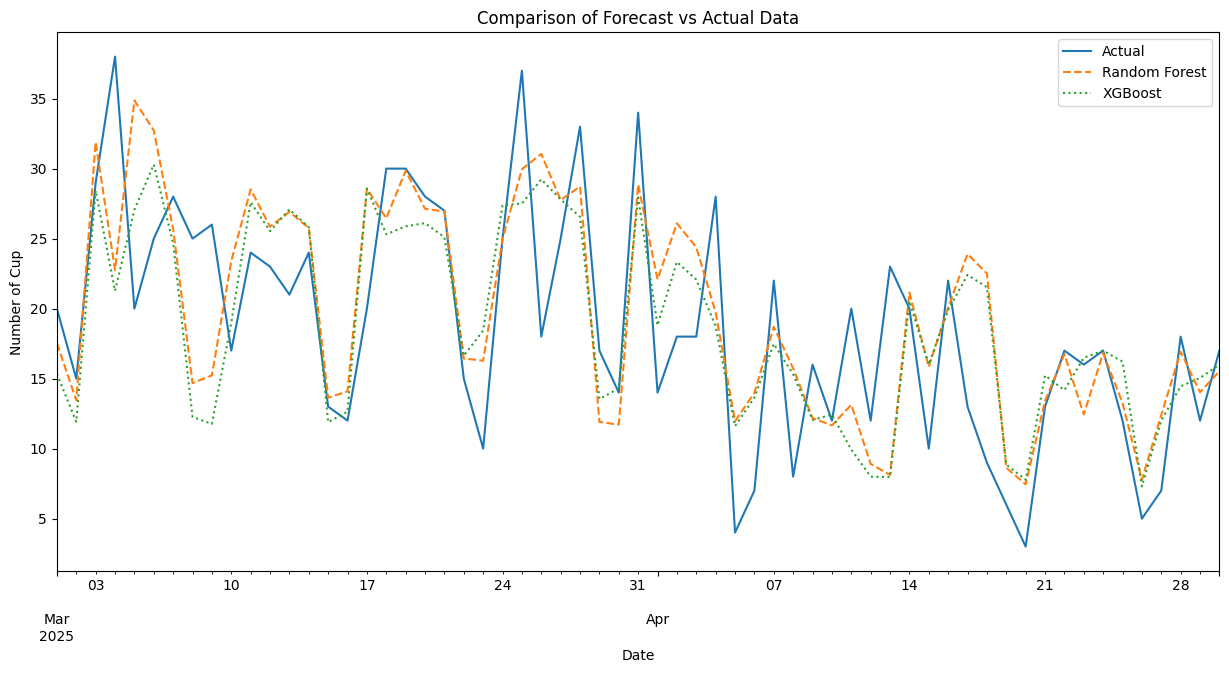

In [29]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Cup')
plt.xlabel('Date')
plt.legend()
plt.show()

In [30]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

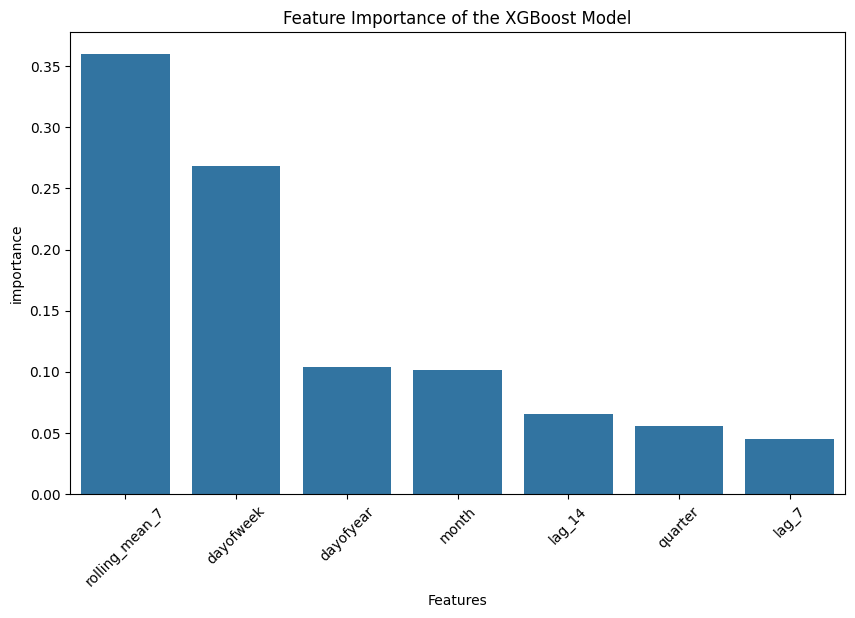

In [31]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

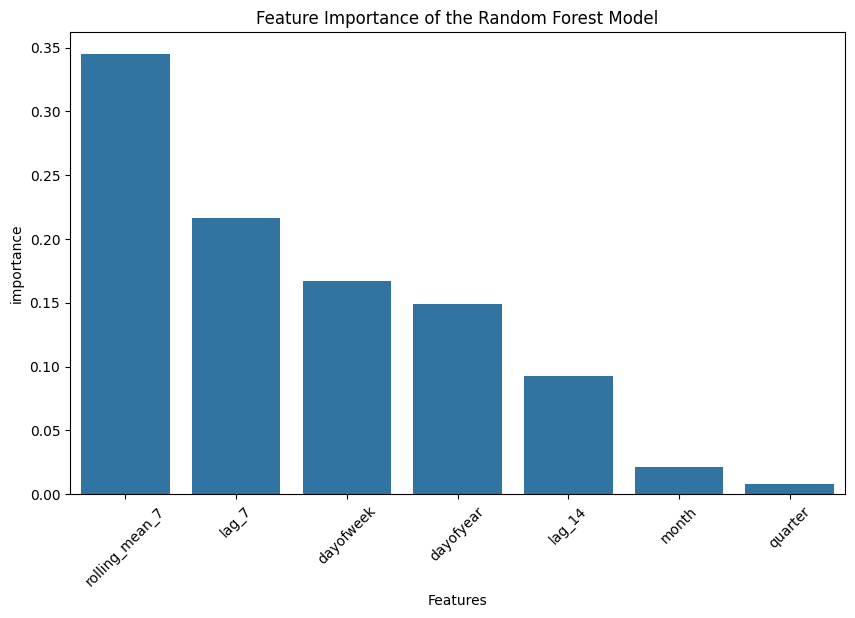

In [32]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [19]:
!pip install prophet

In [33]:
from prophet import Prophet

In [34]:
prophet_preds = {}

for coffee in daily_item_counts['coffee_name'].unique():
    print(f"\n===== Prophet forecast for: {coffee} =====")


===== Prophet forecast for: Americano =====

===== Prophet forecast for: Americano with Milk =====

===== Prophet forecast for: Cappuccino =====

===== Prophet forecast for: Cocoa =====

===== Prophet forecast for: Cortado =====

===== Prophet forecast for: Espresso =====

===== Prophet forecast for: Hot Chocolate =====

===== Prophet forecast for: Latte =====


In [35]:
# เลือกข้อมูลเฉพาะเมนู
coffee_data = daily_item_counts[daily_item_counts['coffee_name'] == coffee].copy()

In [36]:
    # เตรียมข้อมูลให้เป็นรูปแบบ ds, y
    df_prophet = coffee_data[['date', 'count']].rename(columns={'date': 'ds', 'count': 'y'})

In [37]:
    # สร้างและ train model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmppjk4m_8w/0wtxpup1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppjk4m_8w/885t7pqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6177', 'data', 'file=/tmp/tmppjk4m_8w/0wtxpup1.json', 'init=/tmp/tmppjk4m_8w/885t7pqo.json', 'output', 'file=/tmp/tmppjk4m_8w/prophet_modeltgjpmkol/prophet_model-20250921033653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:36:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:36:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [38]:
    # สร้าง dataframe สำหรับอนาคต 60 วัน
    future = model.make_future_dataframe(periods=60)
    forecast = model.predict(future)

/tmp/ipython-input-212428621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_result['coffee_name'] = coffee


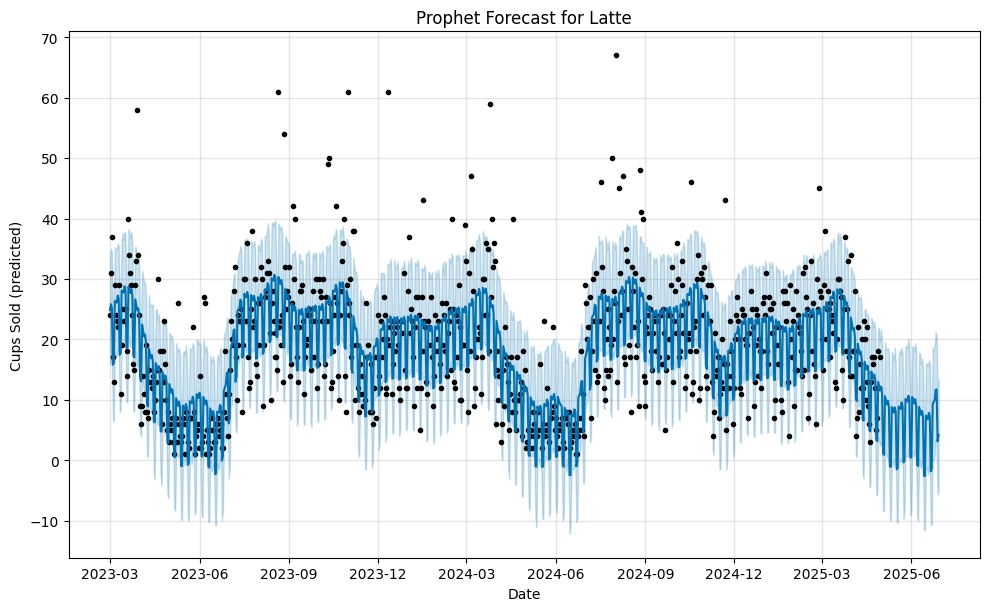

In [39]:
    # เก็บผลลัพธ์
    forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast_result['coffee_name'] = coffee
    prophet_preds[coffee] = forecast_result
    # Plot
    fig = model.plot(forecast)
    plt.title(f"Prophet Forecast for {coffee}")
    plt.xlabel("Date")
    plt.ylabel("Cups Sold (predicted)")
    plt.show()

In [40]:
# รวมผลลัพธ์ทั้งหมด
prophet_all = pd.concat(prophet_preds.values())
display(prophet_all.tail(20))

,ds,yhat,yhat_lower,yhat_upper,coffee_name
831,2025-06-10,8.164474,-0.731931,17.699121,Latte
832,2025-06-11,7.521224,-1.366038,16.012300,Latte
833,2025-06-12,8.158380,-0.181204,16.832065,Latte
834,2025-06-13,7.133950,-1.673654,15.450102,Latte
835,2025-06-14,-2.579471,-11.642345,6.664549,Latte
836,2025-06-15,-2.617595,-11.367858,6.231124,Latte
837,2025-06-16,7.392054,-1.778288,16.100803,Latte
838,2025-06-17,7.042041,-1.054746,15.945300,Latte
839,2025-06-18,6.775047,-2.382409,15.645475,Latte
840,2025-06-19,7.851979,-0.828951,16.575322,Latte
